<a href="https://colab.research.google.com/github/Pandatoey/LAB229351/blob/main/%E0%B8%AA%E0%B8%B3%E0%B9%80%E0%B8%99%E0%B8%B2%E0%B8%82%E0%B8%AD%E0%B8%87_229351_LAB10_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ปฏิบัติการครั้งที่ 8

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 24 เดือนสุดท้ายและ Training set เป็นข้อมูลก่อนหน้าทั้งหมด
3. ลองสร้างโมเดล Holt-Winters แบบต่างๆ (damped, non-damped, additive, multiplicative etc.) แล้วระบุโมเดลที่ดีที่ให้ค่า RMSE บน test set น้อยที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [16]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-29 11:59:51--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.47.56, 172.66.44.200, 2606:4700:310c::ac42:2cc8, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.47.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.01s   

2025-09-29 11:59:51 (12.3 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [17]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

In [18]:
#1
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
def parser(dates):
  return datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date',
                                        date_parser=parser)

print (data.tail())

            MaxTemp
Date               
2019-07-27     26.2
2019-07-28     34.2
2019-07-29     34.4
2019-07-30     33.5
2019-07-31     30.7


/tmp/ipython-input-2117903979.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],


ข้อมูลที่ได้เป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วย method `resample`

In [19]:
data_monthly = data['MaxTemp'].resample("ME").mean()

data_monthly.head()

,MaxTemp
Date,
1998-01-31,31.687097
1998-02-28,33.685714
1998-03-31,37.103226
1998-04-30,37.910000
1998-05-31,35.848387


In [20]:
train = data_monthly.iloc[:-24]
test  = data_monthly.iloc[-24:]

In [21]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

In [28]:
#additive model
models = {}

# additive, no damped
models['additive'] = ExponentialSmoothing(
    train, trend='add', seasonal='add', seasonal_periods=12).fit()

In [29]:
y_pred1 = models['additive'].forecast(len(test))
rmse_additive = rmse(test,y_pred1)

In [30]:
print(rmse_additive )

1.1669523392712184


In [31]:
#multiplicative model
models = {}

# multiplicative, no damped
models['multiplicative'] = ExponentialSmoothing(
    train, trend='add', seasonal='mul', seasonal_periods=12).fit()

In [32]:
y_pred2 = models['multiplicative'].forecast(len(test))
rmse_multiplicative = rmse(test,y_pred2)

In [33]:
print(rmse_multiplicative)

1.1639766564724707


In [34]:
# additive, damped
models = {}
models['add_damped'] = ExponentialSmoothing(
    train, trend='add', damped_trend=True, seasonal='add', seasonal_periods=12).fit()

In [35]:
y_pred3 = models['add_damped'].forecast(len(test))
rmse_add_damped = rmse(test,y_pred3)

In [36]:
print(rmse_add_damped)

1.1134955121933203


In [37]:
# multiplicative, damped
models = {}
models['mul_damped'] = ExponentialSmoothing(
    train, trend='add', damped_trend=True, seasonal='mul', seasonal_periods=12).fit()

In [39]:
y_pred4 = models['mul_damped'].forecast(len(test))
rmse_mul_damped = rmse(test,y_pred4)

In [40]:
print(rmse_mul_damped)

1.1062443526370112


model ที่ให้ค่า rmse น้อยสุดคือ multiplicative, damped ซึ่ง rmse = 1.106

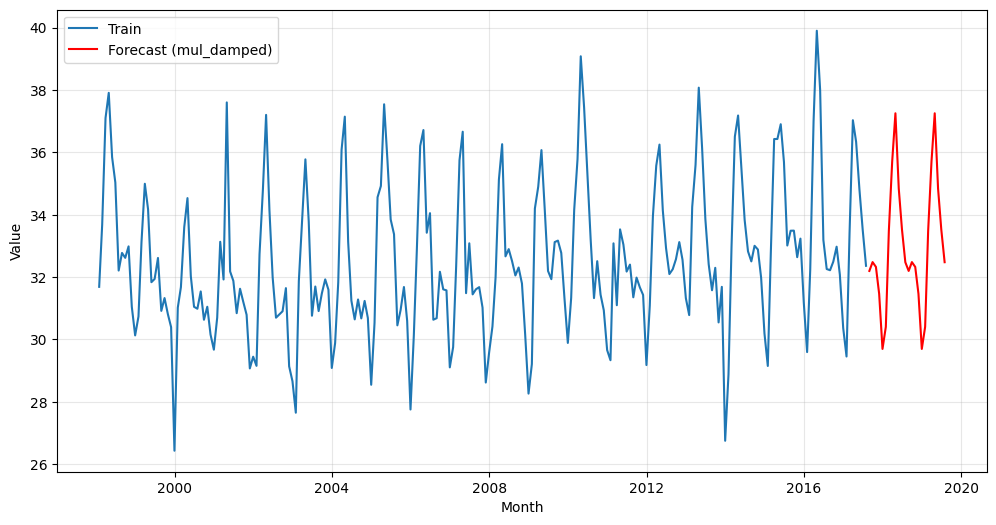

In [43]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, y_pred4.values, label='Forecast (mul_damped)', color='red')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()